# Test de création d'isochrones avec de nouvelles formes

On se base sur l'API de Navitia pour obtenir les points qui permettent de composer les isochrones.

Pour les besoins de ce tests, nous allons récupérer, à partir d'une requête sur un noeud d'origine, les noeuds et le temps nécessaire pour les atteindre avec les paramètres suivants:
* *durée maximale*: **30 minutes**
* *adresse de départ*: **"Châtelet - Les Halles, Place Basse, Quartier des Halles, Quartier Les Halles, Paris 1er Arrondissement, Paris, Île-de-France, France métropolitaine, 75001, France"**
* *date*: **2018-11-15** (*yyyy-mm-dd*)
* *heure*: **08:00**
* *API*: **Navitia** ([journeys](https://doc.navitia.io/#journeys))

## Explorer les requêtes et les premiers résultats
### Préparation
Tout d'abord, on importe le chemin du module dans le path

In [ ]:
# Add module to path
import os
import sys

add_path = os.getcwd().replace('experiments', '')
sys.path.append(add_path)

### Utilisation de la librairie développée spécifiquement
Ensuite on lance le module avec les paramètres. Le temps de traitement peut être long car, pour les besoins du test, nous récupérons tous les plus courts chemins (*modes, stations, durées, ...*) du noeuds d'origine vers chaque noeud retourné par la requête initiale (*qui donne tous les noeuds permettant de créer un isochrone avec une durée maximale de X minutes*). 

In [ ]:
from dotenv import load_dotenv
import docopt
import json
from pathlib import Path
from csv_to_json import csv_to_json
from isos_and_intersections import GetIso

param_csv = os.path.join(add_path, "params/test_journeys.csv")
param_json = os.path.join(add_path, "params/test_journeys.json")
places_cache = os.path.join(add_path, "params/places_cache.json")

#Parameters
env_path = Path(add_path) / '.env'
load_dotenv(dotenv_path=env_path)
TOKEN = os.getenv("NAVITIA_TOKEN")

columns_with_array_of_str = [
    "colors_iso",
    "addresses",
    "excluded_modes",
    "durations"
    ]

#JSON INPUT
json_file = csv_to_json(param_csv, param_json, ";", columns_with_array_of_str)

gdf_global = GetIso(param_json, places_cache, api="navitia", token=TOKEN).get_all_isos()

Ensuite on transforme les GeoDataframes obtenus en GeoJSON pour les lire et les cartographier plus facilement avec Bokeh. 

In [ ]:
import geopandas as gpd
import geojson

from geo_functions import gdf_to_geojson, geosource

#Filter: no "NR"
lines = gdf_global["journeys_details_lines"]
pts = gdf_global["journeys_details_pts"]
# filter_lines = lines.loc[lines["mode"] != "NR"]
# filter_pts = pts.loc[pts["mode"] != "NR"]

if lines is None:
    source_lines = geosource("lines_test.geojson")
    source_pts = geosource("points_test.geojson")
else:
    #Save to geojson
    lines.to_file("lines_test.geojson", driver="GeoJSON")
    pts.to_file("points_test.geojson", driver="GeoJSON")

    #Transform gdf to geojson
    columns_lines = list(lines.columns)
    columns_pts = list(pts.columns)
    geo_source_lines = gdf_to_geojson(lines, columns_lines, "epsg:3857")
    geo_source_pts = gdf_to_geojson(pts, columns_pts, "epsg:3857")
    source_lines = GeoJSONDataSource(geojson=geo_source_lines)
    source_pts = GeoJSONDataSource(geojson=geo_source_pts)

### Exploration des résultats: cartographie de tous les chemins minimaux
On cartographie les lignes et les noeuds (*colorés en fonction du mode*) qui représentent tous les chemins minimaux entre le noeud d'origine et les X noeuds du réseau atteignables dans le temps donné. 

In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.tile_providers import STAMEN_TONER_BACKGROUND
from bokeh.models import GeoJSONDataSource, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Colorblind8 as cb
from bokeh.transform import factor_cmap
import json
from pyproj import Proj, transform

output_notebook()

#Set origin
lat = 2.3467922
lng = 48.8621487
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3857')
lat,lng = transform(inProj,outProj,lat,lng)
data_ori = {
    "x":[lat],
    "y":[lng],
    "name":["Origin"]
}

ori = ColumnDataSource(data_ori)

# Set colors by mode
modes = ['Métro', 'RER', 'Bus', 'Tramway', 'NR']
palette = [cb[0], cb[1], cb[2], cb[4], 'grey']

color_mapper = CategoricalColorMapper(factors=modes, palette=palette)

# Set the tooltips for hover
TOOLTIPS = [
    ("index", "$index"),
    ("mode", "@mode"),
    ("name", "@name"),
    ("direction", "@direction")
]

p = figure(tooltips=TOOLTIPS)
p.width = 800
p.add_tile(STAMEN_TONER_BACKGROUND, alpha=0.2)


p.multi_line(
    xs='xs',
    ys='ys',
    line_width=2,
    line_color= {'field': 'mode', 'transform': color_mapper},
    line_alpha=0.5,
    source=source_lines,
    legend="Lines"
)


p.circle(
    x='x',
    y='y',
    size = 5,
    color = {'field': 'mode', 'transform': color_mapper},
    source=source_pts,
    legend="Nodes"
)

#Add ori
p.triangle(
    x="x",
    y="y",
    size=20,
    color="red",
    alpha=0.5,
    source=ori,
    legend="Origin"
)

p.legend.click_policy="hide"

#Add a workaround to get a custom legend with geojson
#See https://github.com/bokeh/bokeh/issues/5904#issuecomment-296219499
for factor, color in zip(color_mapper.factors, color_mapper.palette):
    p.square(x=[], y=[], fill_color=color, size=10, line_alpha=0.0, legend=factor)

show(p)

### Exploration des résultats: cartographie des durées et des distances à pied
On peut cartographier les noeuds du réseau issu de la requête principale:
* *avec la durée nécessaire pour les atteindre depuis le noeud d'origine*) => Carte "Duration from origin point"
* *avec le potiential de marche à pied depuis chaque noeud (en fonction du temps restant)*) => Carte "Walkable distance from nodes"

> Les 2 cartes sont liées (le pan et le zoom sont synchronisés sur les 2 cartes). 

In [ ]:
from bokeh.palettes import Viridis256, Magma11, RdYlBu11, Greens9, Inferno256
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.tile_providers import STAMEN_TONER_BACKGROUND
from bokeh.models import GeoJSONDataSource, ColumnDataSource, LinearColorMapper, LogTicker, ColorBar
from bokeh.layouts import gridplot
import json

from geo_functions import gdf_to_geojson

output_notebook()

TOOLTIPS = [
    ("name", "@to_name"),
    ("duration", "@duration"),
    ("walkable_distance", "@walkable_distance")
]

TOOLS = "pan,box_zoom,wheel_zoom,box_select,lasso_select,save,reset,hover"

#####################
#DURATION FROM ORIGIN
#####################
#Create color mapper
color_mapper = LinearColorMapper(palette=Viridis256)

#Prepare the data
columns_nodes = list(gdf_global["journeys_points"].columns)
nodes = gdf_to_geojson(gdf_global["journeys_points"], columns_nodes, "epsg:3857")

p = figure(
    title="Duration from origin point",
    tooltips=TOOLTIPS, 
    tools=TOOLS
)
p.width = 450
p.add_tile(STAMEN_TONER_BACKGROUND, alpha=0.2)

source_circles = GeoJSONDataSource(geojson=nodes)
p.circle(
    x='x',
    y='y',
    fill_color={'field': 'duration', 'transform': color_mapper},
    fill_alpha=0.5,
    line_color="white",
    line_alpha=0.0,
    size=10,
    source=source_circles
)

#Add ori
p.triangle(
    x="x",
    y="y",
    size=20,
    color="red",
    alpha=0.5,
    source=ori,
    legend="Origin"
)

color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=120, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'right')
############################################

#####################
#WALKABLE DISTANCE
#####################
#Create color mapper
color_mapper = LinearColorMapper(palette=Viridis256)

p2 = figure(
    title="Walkable distance from nodes (meters)",
    x_range=p.x_range, 
    y_range=p.y_range,
    tooltips=TOOLTIPS,
    tools=TOOLS
)
p2.width = 450
p2.add_tile(STAMEN_TONER_BACKGROUND, alpha=0.2)

p2.circle(
    x='x',
    y='y',
    fill_color={'field': 'walkable_distance', 'transform': color_mapper},
    fill_alpha=0.5,
    line_color="white",
    line_alpha=0.0,
    size=10,
    source=source_circles
)

#Add ori
p2.triangle(
    x="x",
    y="y",
    size=20,
    color="red",
    alpha=0.5,
    source=ori,
    legend="Origin"
)

color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=120, border_line_color=None, location=(0,0))
p2.add_layout(color_bar, 'right')
############################################

grid = gridplot(
    [
        [p,p2]
    ],
    toolbar_location='right'
     )


show(grid)

## Etude de variations de représentations
### Différentes manières de représenter les isochrones
#### Les buffers autour des stations et leur union
On essaie de reproduire la méthode employée par l'API Navitia:
* 1) temps de marche à pied disponible => temps maximum de déplacement - temps de déplacement
* 2) distance de marche à pied => vitesse marche * temps de marche disponible
* 3) buffer de cette distance pour chaque noeud 
* 4) union des buffers

In [ ]:
import numpy as np

def buffering(point, distance):
    return point.buffer(distance, resolution=16)

pts = gdf_global["journeys_points"]
#Prepare the data (get buffer from walkable distance)
pts["buffer"] = np.vectorize(buffering)(pts["geometry"], pts["walkable_distance"])
pts = pts.rename(columns={'geometry': 'pts'})
pts = pts.rename(columns={'buffer': 'geometry'}).set_geometry('geometry')

In [ ]:
from shapely.ops import cascaded_union

#########
# BUFFERS
#########
#Create color mapper
color_mapper = LinearColorMapper(palette=Viridis256)

#Prepare the data
columns_pts = list(pts.columns)
nodes = gdf_to_geojson(pts, columns_pts, "epsg:3857")

p = figure(
    title="Buffers",
    tooltips=TOOLTIPS, 
    tools=TOOLS
)
p.width = 450
p.add_tile(STAMEN_TONER_BACKGROUND, alpha=0.2)

source_pts = GeoJSONDataSource(geojson=nodes)
p.patches(
    xs='xs',
    ys='ys',
    fill_color={'field': 'duration', 'transform': color_mapper},
    fill_alpha=0.5,
    line_color="white",
    line_alpha=0.0,
    source=source_pts
)

#Add ori
p.triangle(
    x="x",
    y="y",
    size=20,
    color="red",
    alpha=0.5,
    source=ori,
    legend="Origin"
)

# color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
#                      label_standoff=120, border_line_color=None, location=(0,0))
# p.add_layout(color_bar, 'right')

########
# UNION
########

#Prepare the data
columns_pts = list(pts.columns)
nodes = gdf_to_geojson(pts, columns_pts, "epsg:3857")

p2 = figure(
    title="Union of buffers",
    tooltips=TOOLTIPS, 
    tools=TOOLS,
    x_range=p.x_range, 
    y_range=p.y_range,
)
p2.width = 450
p2.add_tile(STAMEN_TONER_BACKGROUND, alpha=0.2)

#Union of buffers
one_buffer = gpd.GeoSeries(cascaded_union(pts["geometry"]))
buffer = gpd.GeoDataFrame()
buffer["geometry"] = one_buffer
buffer_json = gdf_to_geojson(buffer, [], "epsg:3857")

source_buffer = GeoJSONDataSource(geojson=buffer_json)
p2.patches(
    xs='xs',
    ys='ys',
    fill_color="green",
    fill_alpha=0.5,
    line_color="white",
    line_alpha=0.0,
    source=source_buffer
)

#Add ori
p2.triangle(
    x="x",
    y="y",
    size=20,
    color="red",
    alpha=0.5,
    source=ori,
    legend="Origin"
)

grid = gridplot(
    [
        [p,p2]
    ],
    toolbar_location='right'
     )

show(grid)

#### Les isochrones pédestres en fonction du réseau viaire autour des stations et leur union
##### Récupérer le réseau pédestre de la zone

In [ ]:
# Add module to path
import os
import sys
import time
import json
import osmnx as ox

add_path = os.getcwd().replace('experiments', '')
sys.path.append(add_path)

from osmnx_based_functions import graph_with_time

# poly = one_buffer.envelope
# poly, _ = ox.project_geometry(one_buffer.envelope[0], crs={'init':'epsg:3857'}, to_latlong=True)
# network_type = "walk"

# G = ox.graph_from_polygon(poly, network_type=network_type)
edges_path = os.path.join(add_path, "graphs\Paris_20km_edges.json")
nodes_path = os.path.join(add_path, "graphs\Paris_20km_nodes.json")

point = 2.3467922,48.8621487

distance = 20000
G = graph_with_time(point, distance, edges_path, nodes_path, epsg={"init":"epsg:3857"})
# G = ox.project_graph(G)


In [ ]:
# Add module to path
import os
import sys
import time
import json
import osmnx as ox

add_path = os.getcwd().replace('experiments', '')
sys.path.append(add_path)
from graph_utils import df_to_graph


edges_path = os.path.join(add_path, "graphs\Paris_500m_edges.json")
nodes_path = os.path.join(add_path, "graphs\Paris_500m_nodes.json")

G2 = df_to_graph(edges_path, nodes_path, source="source", target="target")



In [ ]:
G2.nodes[25581569]["x"]

##### Tracer de nouveaux "isochrones" en utilisant le réseau: 1ère phase de test

In [ ]:
# import networkx as nx
# from shapely.geometry import Point, LineString

# def make_iso_lines(G, oris, trip_times, inproj=None, outproj=None):
#     """
#     Sources:
#         https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb
#         http://kuanbutts.com/2017/12/16/osmnx-isochrones/
    
#     """
#     xs = []
#     ys = []
#     durations = []
#     if inproj is not None:
#         inProj = Proj(init=inproj)
#         outProj = Proj(init=outproj)
    
#     for ori in oris:
#         center_node = ox.get_nearest_node(G, (ori[0], ori[1]))
        
#         for trip_time in sorted(trip_times, reverse=True):
#             subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

#             node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
#             nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
#             nodes_gdf = nodes_gdf.set_index('id')

#             edge_lines = []
#             for n_fr, n_to in subgraph.edges():
#                 f = nodes_gdf.loc[n_fr].geometry
#                 t = nodes_gdf.loc[n_to].geometry
#                 edge_lines.append(LineString([f,t]))
                
#                 if inproj is not None:
#                     fx,fy = transform(inProj,outProj,f.x,f.y)
#                     tx,ty = transform(inProj,outProj,t.x,t.y)
#                     xs.append([fx,tx])
#                     ys.append([fy,ty])
#                 else:
#                     xs.append([f.x,t.x])
#                     ys.append([f.y,t.y])
                    
#                 durations.append(trip_time)

#     data = {
#             "geometry":edge_lines,
#             "durations":durations,
#             "xs":xs,
#             "ys":ys
#         }   
        
#     return data


import networkx as nx
from shapely.geometry import Point, LineString

def make_iso_lines(G, oris, trip_times, inproj=None, outproj=None):
    """
    Sources:
        https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb
        http://kuanbutts.com/2017/12/16/osmnx-isochrones/
    
    """
    xs = []
    ys = []
    durations = []
    if inproj is not None:
        inProj = Proj(init="epsg:3857")
        outProj = Proj(init="epsg:4326")
    
    X = [ori[0] for ori in oris]
    Y = [ori[1] for ori in oris]

    center_nodes = ox.get_nearest_nodes(G, X, Y, method="kdtree")
        
    for center_node in center_nodes:
        for trip_time in sorted(trip_times, reverse=True):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

            node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
            nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
            nodes_gdf = nodes_gdf.set_index('id')

            edge_lines = []
            for n_fr, n_to in subgraph.edges():
                f = nodes_gdf.loc[n_fr].geometry
                t = nodes_gdf.loc[n_to].geometry
                edge_lines.append(LineString([f,t]))
                
                if inproj is not None:
                    fx,fy = transform(inProj,outProj,f.x,f.y)
                    tx,ty = transform(inProj,outProj,t.x,t.y)
                    xs.append([fx,tx])
                    ys.append([fy,ty])
                else:
                    xs.append([f.x,t.x])
                    ys.append([f.y,t.y])
                    
                durations.append(trip_time)

    data = {
            "geometry":edge_lines,
            "durations":durations,
            "xs":xs,
            "ys":ys
        }   
        
    return data

In [ ]:
ori_gdf = gdf_global["journeys_points"]
duration = 1800
ori_gdf["time_left"] = duration - ori_gdf["duration"]
oris = [(pt.x, pt.y) for pt in ori_gdf["geometry"]]
durations = list(ori_gdf["time_left"])

In [7]:
import time

def seconds_to_time(seconds, option="all"): 
    milliseconds = int(round(seconds * 1000))
    s, ms = divmod(milliseconds, 1000)
    m, s = divmod(s, 60)
    h, m = divmod(m, 60)
    time_format = "%02d:%02d:%02d:%02d" % (h, m, s, ms)
    
    if option == "all":
        return time_format, milliseconds
    elif option == "ms":
        return milliseconds
    elif option == "format":
        return time_format
    

def time_profile(start, option="all"):
    end = time.time()
    seconds = seconds_to_time(end - start, option=option)
    
    return seconds

In [ ]:
start = time.time()

# oris = [
#     (48.861156, 2.349697),
#     (48.804803, 2.064277),
#     (48.792269, 2.532459)
# ]

ori = (48.861156, 2.349697)
value = 0.000001
oris = [
    (ori[0]+(value*i),ori[1]+(value*i)) for i in range(0,999)
             ]
trip_times = [
    10
]

lines = make_iso_lines(G, oris, trip_times, inproj="epsg:4326", outproj="epsg:3857")
print (time_profile(start, option = "format"))

In [1]:
from bokeh.palettes import Reds9

#########
# LINES
#########
#Create color mapper
color_mapper = LinearColorMapper(palette=Reds9)

p = figure(
    title="Buffers",
    tools=TOOLS
)
p.width = 450
p.add_tile(STAMEN_TONER_BACKGROUND, alpha=0.2)

data = {
    "xs":lines["xs"],
    "ys":lines["ys"],
    "durations":lines["durations"]
}
source_lines = ColumnDataSource(data)
p.multi_line(
    xs='xs',
    ys='ys',
    source=source_lines,
    color={'field': 'durations', 'transform': color_mapper},
#     fill_color={'field': 'duration', 'transform': color_mapper},
#     fill_alpha=0.5,
#     line_color="white",
#     line_alpha=0.0,
#     source=source_pts
)


show(p)


NameError: name 'LinearColorMapper' is not defined

Le test précédent semble fonctionner pour les 3 points données. Essayons avec l'ensemble des noeuds.

##### Tracer de nouveaux "isochrones" en utilisant le réseau: 2nde phase de test

In [1]:
# Add module to path
import os
import sys
import time
import json

add_path = os.getcwd().replace('experiments', '')
sys.path.append(add_path)

from dotenv import load_dotenv
import docopt
import json
from pathlib import Path
from csv_to_json import csv_to_json
from isos_and_intersections import GetIso

param_csv = os.path.join(add_path, "params/test_journeys.csv")
param_json = os.path.join(add_path, "params/test_journeys.json")
places_cache = os.path.join(add_path, "params/places_cache.json")


#Parameters
env_path = Path(add_path) / '.env'
load_dotenv(dotenv_path=env_path)
TOKEN = os.getenv("NAVITIA_TOKEN")

columns_with_array_of_str = [
    "colors_iso",
    "addresses",
    "excluded_modes",
    "durations"
    ]

#JSON INPUT
json_file = csv_to_json(param_csv, param_json, ";", columns_with_array_of_str)

start = time.time()
gdf_global = GetIso(param_json, places_cache, api="navitia", token=TOKEN).get_all_isos()
print ("TOTAL GDF_GLOBAL",time_profile(start, option = "format"))

URL https://api.navitia.io/v1/coverage/fr-idf/journeys?from=2.3447555;48.8511485&datetime=2018-12-06T08:00&max_duration=1200


C:\Users\thomas\Documents\code\iso\app_iso\code\osmnx_based_functions.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf_lines.drop_duplicates(subset=["source","target"],inplace=True)
C:\Users\thomas\Documents\code\iso\app_iso\code\osmnx_based_functions.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf_lines['xs'] = gdf_lines.apply(getLineCoords, geom='line', coord_type='x', axis=1)
C:\Users\thomas\Documents\code\iso\app_iso\code\osmnx_based_functions.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

polys 00:00:08:243
sym_diff 00:02:00:933


NameError: name 'time_profile' is not defined

In [2]:
id_ = "all_08h00_Chatelet"
address = "90, Boulevard Saint-Germain, Quartier de la Sorbonne, Paris 5e Arrondissement, Paris, Île-de-France, France métropolitaine, 75005, France"
duration = 20
key = id_, address, duration

gdf = gdf_global["isolines"][key]["gdf_lines"]
polys = gdf_global["isolines"][key]["polys_union"]
sym_diff = gdf_global["isolines"][key]["sym_diff"]
difference = gdf_global["isolines"][key]["difference"]
# inners = sym_diff["difference"]
# outers = sym_diff["intersection"]
inners = sym_diff
outers = polys

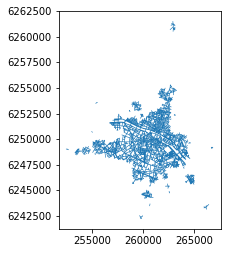

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [7]:
add_path = os.getcwd().replace('experiments', '')
sys.path.append(add_path)

import geopandas as gpd
import geojson
from bokeh.plotting import figure, show
from bokeh.palettes import Viridis256, Magma11, RdYlBu11, Greens9, Inferno256, Viridis4
from bokeh.io import output_notebook
from bokeh.tile_providers import STAMEN_TONER_BACKGROUND
from bokeh.models import GeoJSONDataSource, ColumnDataSource, CategoricalColorMapper, LinearColorMapper
from bokeh.palettes import Colorblind8 as cb
from bokeh.transform import factor_cmap
import json
from pyproj import Proj, transform

from geo_functions import gdf_to_geojson

output_notebook()

#Source: https://stackoverflow.com/a/51520122


#Prepare the data
#Inners
inners = inners[["geometry"]].fillna(0)
columns_inners = list(inners.columns)
inners_source = gdf_to_geojson(inners, columns_inners, "epsg:3857")

inners_source = GeoJSONDataSource(geojson=inners_source)

#Outers
outers = outers[["geometry"]].fillna(0)
columns_outers = list(outers.columns)
outers_source = gdf_to_geojson(outers, columns_outers, "epsg:3857")

outers_source = GeoJSONDataSource(geojson=outers_source)

color_mapper = LinearColorMapper(palette=Viridis4)

#Set origin
lat = 2.34472
lng = 48.85103
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3857')
lat,lng = transform(inProj,outProj,lat,lng)
data_ori = {
    "x":[lat],
    "y":[lng],
    "name":["Origin"]
}

ori = ColumnDataSource(data_ori)

p = figure(
    title="Buffers"
)

p.width = 800
p.add_tile(STAMEN_TONER_BACKGROUND, alpha=0.2)

#INNERS
p.patches(
    xs='xs',
    ys='ys',
    color="red",
    alpha=0.5,
#     line_width=2,
#     line_color= {'field': 'durations', 'transform': color_mapper},
#     line_alpha=0.5,
    source=inners_source,
    legend="SYM_DIFF"
)

#OUTERS
p.patches(
    xs='xs',
    ys='ys',
    color="blue",
    alpha=0.5,
#     line_width=2,
#     line_color= {'field': 'durations', 'transform': color_mapper},
#     line_alpha=0.5,
    source=outers_source,
    legend="DIFFERENCE"
)


#Add ori
p.triangle(
    x="x",
    y="y",
    size=20,
    color="green",
    alpha=0.5,
    source=ori,
    legend="Origin"
)

p.legend.click_policy="hide"


show(p)

Loading BokehJS ...

In [5]:
import pandas as pd
from bokeh.palettes import Viridis256, Magma11, RdYlBu11, Greens9, Inferno256, Viridis4
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.tile_providers import STAMEN_TONER_BACKGROUND
from bokeh.models import GeoJSONDataSource, ColumnDataSource, LinearColorMapper, LogTicker, ColorBar
from bokeh.layouts import gridplot
import json
from pyproj import Proj, transform

output_notebook()

# isolines = test["isolines"].apply(pd.Series)
# id_ = "all_08h00_Chatelet"
# address = "90, Boulevard Saint-Germain, Quartier de la Sorbonne, Paris 5e Arrondissement, Paris, Île-de-France, France métropolitaine, 75005, France"
# duration = 20
# key = id_, address, duration

# dict_ = gdf_global["isolines"][key]

#########
# LINES
#########
#Create color mapper
color_mapper = LinearColorMapper(palette=Inferno256)

p = figure(
    title="Lines",
#     tools=TOOLS
)
p.width = 800
p.add_tile(STAMEN_TONER_BACKGROUND, alpha=0.2)

# data = {
#     "xs":dict_["xs"],
#     "ys":dict_["ys"],
#     "durations":dict_["durations"]
# }
# source_lines = ColumnDataSource(data)
p.multi_line(
    xs='xs',
    ys='ys',
    line_width=3,
    source=ColumnDataSource(gdf),
    color = "green"
#     color={'field': 'durations', 'transform': color_mapper},
)

#Set origin
lat = 2.34472
lng = 48.85103
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3857')
lat,lng = transform(inProj,outProj,lat,lng)
data_ori = {
    "x":[lat],
    "y":[lng],
    "name":["Origin"]
}

ori = ColumnDataSource(data_ori)

#Add ori
p.triangle(
    x="x",
    y="y",
    size=20,
    color="red",
    alpha=0.5,
    source=ori,
    legend="Origin"
)



show(p)

Loading BokehJS ...

#### Simplifications d'isochrones et propositions de représentations

In [ ]:
# Add module to path
import os
import sys

add_path = os.getcwd().replace('experiments', '')
sys.path.append(add_path)

from spatial_cutting import get_transit_network

